In [35]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import optimize
from scipy import interpolate

In [36]:
def u(c):
    u_fun = lambda c: np.log(c)
    u = u_fun(c)
    
    return u

In [37]:
def u_prime(c):
    u_fun = lambda c: 1/c
    u = u_fun(c)
    
    return u

In [38]:
def euler(k, s, k1, beta, k_grid, g, mode):
    
    k1 = np.exp(k1)
    f = np.zeros((2))
    f1 = np.zeros((2))
    
    f[0] = 0.9 * k ** 0.3 + 0.3 * k
    f[1] = 1.1 * k ** 0.3 + 0.9 * k
    
    f1[0] = 0.9 * k1 ** 0.3 + 0.3 * k1
    f1[1] = 1.1 * k1 ** 0.3 + 0.9 * k1
    
    delta = 1
    c_prime0 = 0.3 * 0.9 * k1 ** (0.3 - 1) + 0.3 + 1 - delta
    c_prime1 = 0.3 * 1.1 * k1 ** (0.3 - 1) + 0.9 + 1 - delta
    
    k2_0 = interpolate_policy_function(k1, g, 0, k_grid, mode)
    k2_1 = interpolate_policy_function(k1, g, 1, k_grid, mode)
    
    lhs = u_prime( f[s] - k1 )
    
    rhs = beta * ( 0.5 * u_prime( f1[0] - k2_0 ) * (c_prime0) + 0.5 * u_prime( f1[1] - k2_1 ) * (c_prime1) )
    
    euler_eq = lhs - rhs
    
    return euler_eq

In [39]:
def interpolate_policy_function(capital, g, s, k_grid, mode):
 
    if mode == 0:   # PIECEWISE LINEAR INTERPOLATION
        val = np.interp(capital, k_grid, g[:, s])

    elif mode == 1:   # POLYNOMIAL OF DEGREE 5
        interpolant = np.polyfit(k_grid, g[:, s], 5)
        val = np.polyval(interpolant, capital)

    elif mode == 99:   # Chebyshev polynomial of degree 5
        interpolant = np.polynomial.chebyshev.chebfit(k_grid, g[:, s],5)
        val = np.polynomial.chebyshev.chebval(capital, interpolant)    
        
    else:   # CUBIC SPLINES
        interpolant = interpolate.CubicSpline(k_grid, g[:, s])
        val = interpolant(capital)

    return val

In [40]:
def actionvalue(g, N, k_index, k_grid, beta, mode): # solve for optimal k1 in each state S given possible k2
    
    k = k_grid[k_index]
    
    action_value = np.zeros((N,2))
    c = np.zeros_like(action_value)

    for s in range(2):
        for ii in range(N):
            
            func = lambda k1_log: euler(k, s, k1_log, beta, k_grid, g, mode)
            k1_log = optimize.fsolve(func,[-5])
            k1 = math.exp(k1_log)
            
            action_value[ii,s] = k1
            
    return action_value

In [41]:
def pf_update_iteration(g, N, k_grid, beta, mode):

    g_prime = np.zeros_like(g)
    
    for ii in range(N):
        for s in range(2):
            g_prime[ii,s] = actionvalue(g, N, ii, k_grid, beta, mode)[ii,s]
    
    return g_prime

In [42]:
def solve_model(N_in, mode=0, beta=0.9, max_iterations=10000, threshold=1e-5):
    
    beta = beta
    N = N_in      # number of grid-points for the capital grid
    k_low = 0.001 # lower bound for the capital grid
    k_high = 1    # upper bound for capital grid
    k_grid = np.linspace(k_low, k_high, N) #grid for capital
    
    difference_list = []
    
    g = np.zeros((N_in,2))
    
    for iteration in range(max_iterations): #iterate until policy functions converge
        print('Iteration: {}'.format(iteration + 1))

        g_new = pf_update_iteration(g, N, k_grid, beta, mode)
        
        difference = np.max(np.abs(g - g_new))
        difference_list.append(difference)

        g = g_new.copy()

        if difference < threshold:
            print('Converged after iteration {}'.format(iteration + 1))
            break
    
    model = {}
    model['N'] = N
    model['pol'] = g
    model['beta'] = beta
    model['kgrid'] = k_grid
    
    return model

In [43]:
def plot_policy(model):
    plt.figure()
    plt.plot(model['kgrid'], model['pol'][:, 0], label='Low')
    plt.plot(model['kgrid'], model['pol'][:, 1], label='High')
    plt.xlabel('k')
    plt.ylabel("k'")
    plt.title('Policy function')
    plt.legend()
    plt.show();

**Solution**

In [33]:
model_50 = solve_model(50)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Converged after iteration 16


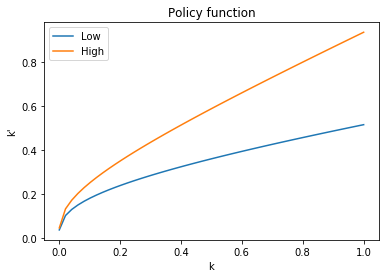

In [34]:
plot_policy(model_50)

In [44]:
model_50 = solve_model(50,mode=1)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Converged after iteration 16


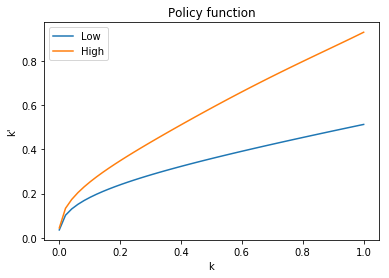

In [45]:
plot_policy(model_50)